Setup and necessary packages

In [1]:
# Downgrade pip to a version before the strict metadata check was enforced.
# This will allow it to install hdmf-zarr despite its typo.
!pip install 'pip<24.1'

DEPRECATION: hdmf-zarr 0.1.6 has a non-standard dependency specifier pynwb>=2.0.0setuptools. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of hdmf-zarr or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [224]:
!pip install mne

  Using cached scipy-1.16.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (61 kB)
Using cached scipy-1.16.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (35.3 MB)
DEPRECATION: hdmf-zarr 0.1.6 has a non-standard dependency specifier pynwb>=2.0.0setuptools. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of hdmf-zarr or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires pydantic>=2.9.2, but you have pydantic 1.10.22 which is incompatible

In [2]:
# Clean install of AJILE12 on Google Colab; this is to prevent overwriting conflicts. You can run this once for each new run instance on colab.
%cd /
 # removes old version of AJILE12 if it exists
%rm -rf /content/Neuromatch-AJILE12/
# change to content directory where AJILE12 will be installed
%cd /content

/
/content


In [3]:
### if running on Google Colab, run this cell once, then restart the runtime and run the rest of the notebook
import os
if "COLAB_GPU" in os.environ:
    !git clone https://github.com/neurovium/Neuromatch-AJILE12
    %cd Neuromatch-AJILE12
    %pip install -e .

Cloning into 'Neuromatch-AJILE12'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 323 (delta 10), reused 0 (delta 0), pack-reused 298 (from 1)
Receiving objects: 100% (323/323), 10.07 MiB | 19.71 MiB/s, done.
Resolving deltas: 100% (144/144), done.
/content/Neuromatch-AJILE12
Obtaining file:///content/Neuromatch-AJILE12
  Preparing metadata (setup.py) ... done
  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.1 MB)
DEPRECATION: hdmf-zarr 0.1.6 has a non-standard dependency specifier pynwb>=2.0.0setuptools. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of hdmf-zarr or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found a

In [4]:
# Numerical and plotting packages
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import natsort
import matplotlib.pyplot as plt
from scipy.signal import sosfiltfilt, butter, hilbert

# Toolbox for data analysis
import mne

In [5]:
# Libraries needed for this notebook to interact with the DANDI API
from pynwb import NWBHDF5IO
from dandi.dandiapi import DandiAPIClient

# Libraries needed for this notebook to interact with NWB events
from ndx_events import LabeledEvents, AnnotatedEventsTable, Events

# FSSpec is a library that allows us to read files from the cloud
import fsspec

# NWB is based on HF5, so we need this library to read NWB files
import h5py

/usr/local/lib/python3.11/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.20) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Data streaming

In [6]:
# SPECIFY subject and session;

sbj, session = 1, 3  # participant 1, session 3

In [7]:
# You can read specific sections within individual data files directly from remote stores such as the DANDI Archive.
# This is especially useful for reading small pieces of data from a large NWB file stored remotely. First, you will need to get the location of the file.
# Now you can get the url of a particular NWB file using the dandiset ID and the path of that file within the dandiset.
with DandiAPIClient() as client:
    asset = client.get_dandiset("000055").get_asset_by_path(
        "sub-{0:>02d}/sub-{0:>02d}_ses-{1:.0f}_behavior+ecephys.nwb".format(sbj, session)
    )
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)

# s3_path is the url of the file on the DANDI Archive. You can now use this url to read the file using pynwb.
# Note that this url path may change if the file is updated on the DANDI Archive. ALWAYS use the "dandiset ID" and "path" to the file within the dandiset to get the url.
s3_path

'https://dandiarchive.s3.amazonaws.com/blobs/e54/21f/e5421ff3-05f6-4d5e-a884-6d3e57a11951'

In [9]:
# You can also read specific sections within individual data files directly from remote stores such as the DANDI Archive.
from fsspec.implementations.cached import CachingFileSystem

# Note, caching is set once per access. If you want to change the cache location, you will need to restart the kernel.
fs = CachingFileSystem(
    fs=fsspec.filesystem("http"),
    cache_storage="nwb-cache",  # Local folder for the cache
)

f = fs.open(s3_path, "rb")
file = h5py.File(f)
io = NWBHDF5IO(file=file, mode='r', load_namespaces=True)
nwbfile = io.read()

# Dataframe that contains the state labels and corresponding time intervals
clabels_orig = nwbfile.intervals['epochs'].to_dataframe()

/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [10]:
# Here is a list of all behavioral state labels in the chosen session;
print(clabels_orig['labels'].unique())

['Blocklist (Data break)' 'Sleep/rest' 'Talk' 'Inactive'
 'Blocklist (Private time)' 'Blocklist (Tether/bandage)' 'Other activity'
 'Talk, TV' 'Computer/phone' 'TV' 'Eat, Talk' 'Blocklist (Experiment)' ''
 'Eat, TV' 'Blocklist (Camera move/zoom)']


In [11]:
# SPECIFY
# Here, we specify which behavioral states we want to filter for. I have created
# two lists corresponding to wakeful active and wakeful inactive states, respectively.
# If you wish to specify another set of states, simply uncomment and edit the
# third list.

behavior = ['Talk', 'Talk, TV', 'Computer/phone', 'TV', 'Eat, Talk', 'Eat, TV', 'Other activity']
#behavior = ['Inactive']
#behavior = ['TV', 'Eat', "Computer/phone"]

In [12]:
# Retrieve time intervals corresponding to the specified states
state_times = clabels_orig[clabels_orig['labels'].isin(behavior)][['start_time', 'stop_time']].to_numpy()

In [13]:
# SPECIFY

reach_events = nwbfile.processing["behavior"].data_interfaces["ReachEvents"]
timestamps_re = reach_events.timestamps[:] # the timing in s of each reach

neural_data = nwbfile.acquisition['ElectricalSeries'].data
sampling_rate = nwbfile.acquisition['ElectricalSeries'].rate

# Specify the time window around the wrist movement;
pre_time = 2 # s
post_time = 1 # s

# Specify the channel
ecog_ch_num = 6

# convert seconds to samples
pre_samples = int(pre_time * sampling_rate)
post_samples = int(post_time * sampling_rate)
total_samples = neural_data.shape[0]
print(total_samples)

43200000


In [14]:
# Filter the wrist event timestamps according to whether or not they happened
# during the state we are interested in;
print('Number of intervals corresponding to the selected state(s):', state_times.shape[0])
start = state_times[:, 0]
stop = state_times[:, 1]
in_any_interval = ((timestamps_re[:, None] >= start) & (timestamps_re[:, None] <= stop)).any(axis=1)
timestamps_re = timestamps_re[in_any_interval]

event_epochs = []

for event_time in timestamps_re:
    # time to sample idx
    event_index = int(event_time * sampling_rate)
    start_idx = event_index - pre_samples
    end_idx = event_index + post_samples

    if start_idx >= 0 and end_idx < total_samples:
        epoch = neural_data[start_idx:end_idx, ecog_ch_num]
        event_epochs.append(epoch)

event_epochs = np.array(event_epochs)  #(n_events, epoch_length, [channels])
print('Number of wrist movement events that happened during the specified state(s):', len(event_epochs))

Number of intervals corresponding to the selected state(s): 266
Number of wrist movement events that happened during the specified state(s): 156


(You can skip this cell)
More advanced - if we want to exclude epochs based on peak to peak threshold for a certain channel

In [206]:
from scipy.signal import butter, filtfilt
import numpy as np

start = state_times[:, 0]
stop = state_times[:, 1]
in_any_interval = ((timestamps_re[:, None] >= start) & (timestamps_re[:, None] <= stop)).any(axis=1)

pre_time = 2  # s pre and post stimulus windows
post_time = 1
sampling_rate = nwbfile.acquisition['ElectricalSeries'].rate
pre_samples = int(pre_time * sampling_rate)
post_samples = int(post_time * sampling_rate)

neural_data = nwbfile.acquisition['ElectricalSeries'].data
ecog_ch_num = 7  # or whatever channel you're interested in

# Convert timestamps to sample indices
timestamps = np.array(reach_events.timestamps)
timestamps = timestamps[in_any_interval]
sample_indices = (timestamps * sampling_rate).astype(int)

epochs = []
for idx, sample_idx in enumerate(sample_indices):
    start_idx = sample_idx - pre_time
    end_idx = sample_idx + post_time

    # skip events too close to the edges
    if start_idx < 0 or end_idx > neural_data.shape[0]:
        print(f"Skipping event {idx} at time {timestamps[idx]:.3f}s (out of bounds)")
        continue

    # Load data snippet for the given channel
    snippet = neural_data[start_idx:end_idx, ecog_ch_num]
    clean_snippet = snippet.copy()
    clean_snippet[np.isnan(clean_snippet)] = 0  # or interpolate
    epochs.append(clean_snippet)

threshold_uv = 200  # microv

clean_epochs = []
for epoch in epochs:
    ptp = np.ptp(epoch)  # peak-to-peak amplitude
    if ptp <= threshold_uv:
        clean_epochs.append(epoch)

print(f"Kept {len(clean_epochs)} out of {len(epochs)} epochs after amplitude filtering.")
event_epochs = np.array(clean_epochs)
print(event_epochs.shape)

Kept 156 out of 156 epochs after amplitude filtering.
(156, 3)


/tmp/ipython-input-206-1721636674.py:18: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  timestamps = np.array(reach_events.timestamps)


In [22]:
average_signal = np.nanmean(event_epochs, axis=0) # shape = (n_samples, )
print(average_signal.shape)

(1500,)


Effective window size : 0.512 (s)


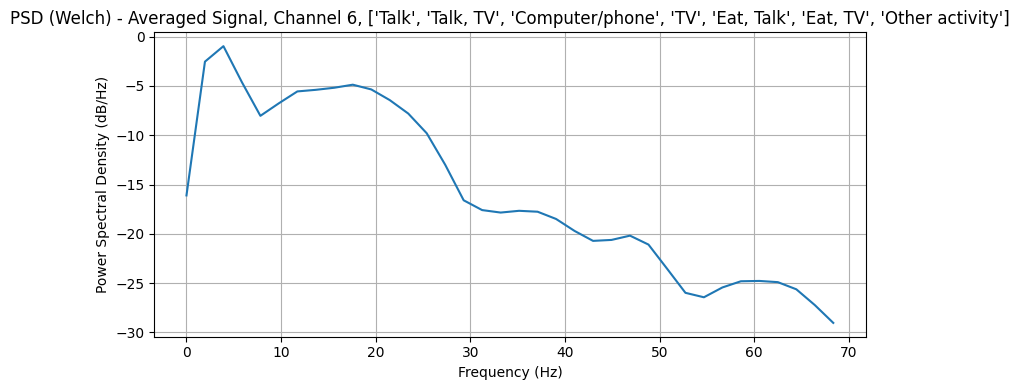

In [23]:
# POWER SPECTRAL DENSITY
from mne.time_frequency import psd_array_welch

psd, freqs = psd_array_welch(average_signal, sfreq=sampling_rate, n_per_seg=128)
freq_cap = (freqs >= 0) & (freqs <= 70)
freqs = freqs[freq_cap]
psd = psd[freq_cap]

plt.figure(figsize=(8, 4))
plt.plot(freqs, 10 * np.log10(psd))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB/Hz)')
plt.title(f'PSD (Welch) - Averaged Signal, Channel {ecog_ch_num}, {behavior}')
plt.grid(True)
plt.tight_layout()
plt.show()

time_vector = np.linspace(-pre_time, post_time, len(average_signal))
#plt.plot(time_vector, average_channel)
#plt.axvline(x=0, color='black', linestyle='--')

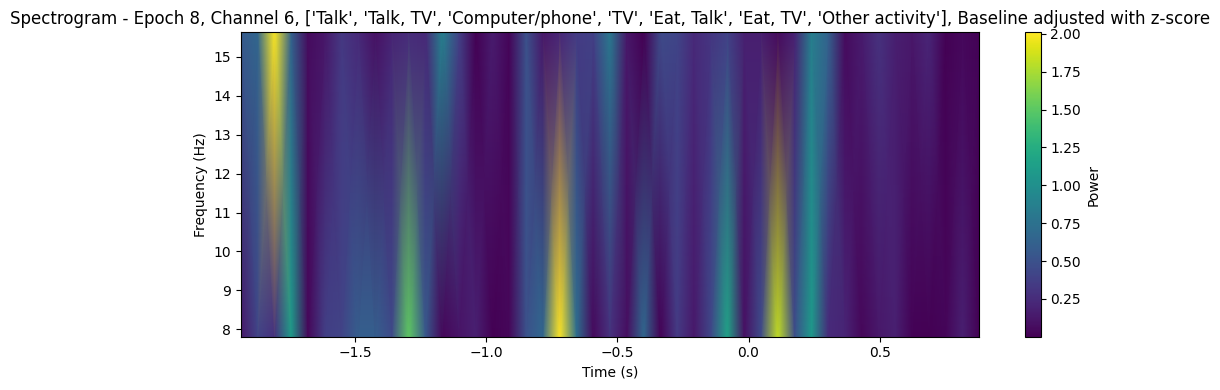

In [27]:
# SPECTROGRAM

from scipy.signal import spectrogram

time = np.linspace(-pre_time, post_time, len(average_signal))
#plt.plot(time, average_channel)
#plt.xlim([-pre_time, post_time])

# lower nperseg, noverlap means higher frequency resolution, lower time resolution
# higher nperseg, noverlap means higher time resolution, lower frequency resolution
f, t, Sxx = spectrogram(average_signal, fs=sampling_rate, nperseg=64, noverlap=32)
t -= pre_time
freq_cap = (f >= 4) & (f <= 16)
f = f[freq_cap]
Sxx = Sxx[freq_cap, :]

# Baseline correction with z-score
baseline_mask = (t >= -2) & (t <= -1) # the interval we use to calculate baseline
baseline_power = Sxx[:, baseline_mask].mean(axis=1, keepdims=True)

# z-score
mu  = baseline_power
sig = Sxx[:, baseline_mask].std(axis=1, keepdims=True)
Sxx_z  = (Sxx - mu) / sig

plt.figure(figsize=(10, 4))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title(f'Spectrogram - Epoch 8, Channel {ecog_ch_num}, {behavior}, Baseline adjusted with z-score')
plt.colorbar(label='Power')
plt.tight_layout()
plt.show()

In [ ]:
from mne.time_frequency import tfr_array_morlet


